# Vision Transformer (ViT) Model for RAF-DB Emotion Recognition


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [31]:
# Constants for RAF-DB (7 emotions)
EMOTIONS = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Anger', 'Neutral']
NUM_CLASSES = len(EMOTIONS)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
IMG_SIZE = 224

In [32]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [33]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image

class RAFDBDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):

        self.root_dir = Path(root_dir) / split
        self.transform = transform
        self.images = []
        self.labels = []

        # RAF-DB has 7 emotion classes (1 → 7)
        for label in range(1, 8):

            class_folder = self.root_dir / str(label)

            if not class_folder.exists():
                print(f"Missing folder: {class_folder}")
                continue

            # Load ALL aligned images
            img_files = list(class_folder.glob('*_aligned.jpg'))

            for img_path in img_files:
                self.images.append(img_path)
                self.labels.append(label - 1)  # make 0–6

        print(f"Loaded {len(self.images)} images for {split} split")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [34]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [35]:
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
# Load datasets
data_dir = "/kaggle/input/datasets/shuvoalok/raf-db-dataset/DATASET" 

In [37]:
print("Loading RAF-DB datasets...")
train_dataset = RAFDBDataset(data_dir, split='train', transform=train_transform)
test_dataset = RAFDBDataset(data_dir, split='test', transform=test_transform)

Loading RAF-DB datasets...
Loaded 12271 images for train split
Loaded 3068 images for test split


In [38]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 12271
Test samples: 3068


In [39]:
# Initialize Vision Transformer model
print("\nInitializing Vision Transformer model...")
vit = models.vit_b_16(pretrained=True)
num_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_features, NUM_CLASSES)
vit = vit.to(device)


Initializing Vision Transformer model...


In [40]:
# Training function with early stopping
def train_vit(model, model_name, train_loader, test_loader, epochs=EPOCHS, patience=5):
    print(f"\n{'='*50}")
    print(f"Training {model_name} with Early Stopping (patience={patience})")
    print('='*50)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    stopped_epoch = epochs
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({'loss': running_loss/(len(train_pbar)), 
                                   'acc': 100.*correct/total})
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                val_pbar.set_postfix({'loss': val_loss/(len(val_pbar)), 
                                     'acc': 100.*correct/total})
        
        val_loss = val_loss / len(test_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}_rafdb.pth')
            print(f"✓ New best model saved with accuracy: {val_acc:.2f}%")
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
            stopped_epoch = epoch + 1
            break
    
    # Final evaluation with best model
    print(f"\n📊 Loading best model for final evaluation...")
    model.load_state_dict(torch.load(f'best_{model_name}_rafdb.pth'))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'predictions': all_preds,
        'true_labels': all_labels,
        'stopped_epoch': stopped_epoch
    }

In [41]:
# Train Vision Transformer
print("\n" + "="*60)
print("STARTING VISION TRANSFORMER TRAINING ON RAF-DB")
print("="*60)

vit_results = train_vit(vit, 'ViT_RAFDB', train_loader, test_loader, patience=5)


STARTING VISION TRANSFORMER TRAINING ON RAF-DB

Training ViT_RAFDB with Early Stopping (patience=5)


Epoch 1/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.68it/s, loss=0.763, acc=70.1] 


✓ New best model saved with accuracy: 70.11%
Epoch 1: Train Loss: 0.9208, Train Acc: 67.17% | Val Loss: 0.7628, Val Acc: 70.11%


Epoch 2/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.71it/s, loss=0.555, acc=80.9] 


✓ New best model saved with accuracy: 80.90%
Epoch 2: Train Loss: 0.6098, Train Acc: 78.48% | Val Loss: 0.5551, Val Acc: 80.90%


Epoch 3/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.70it/s, loss=0.508, acc=81.8] 


✓ New best model saved with accuracy: 81.84%
Epoch 3: Train Loss: 0.5015, Train Acc: 82.21% | Val Loss: 0.5084, Val Acc: 81.84%


Epoch 4/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.73it/s, loss=0.51, acc=82]    


✓ New best model saved with accuracy: 81.98%
Epoch 4: Train Loss: 0.4215, Train Acc: 85.08% | Val Loss: 0.5097, Val Acc: 81.98%
EarlyStopping counter: 1 out of 5


Epoch 5/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.69it/s, loss=0.478, acc=84.1] 


✓ New best model saved with accuracy: 84.09%
Epoch 5: Train Loss: 0.3606, Train Acc: 87.17% | Val Loss: 0.4779, Val Acc: 84.09%


Epoch 6/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.71it/s, loss=0.753, acc=75.2] 


Epoch 6: Train Loss: 0.3156, Train Acc: 88.89% | Val Loss: 0.7527, Val Acc: 75.20%
EarlyStopping counter: 1 out of 5


Epoch 7/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.71it/s, loss=0.535, acc=83.3] 


Epoch 7: Train Loss: 0.2560, Train Acc: 91.00% | Val Loss: 0.5345, Val Acc: 83.34%
EarlyStopping counter: 2 out of 5


Epoch 8/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.70it/s, loss=0.565, acc=82.1]


Epoch 8: Train Loss: 0.2402, Train Acc: 91.25% | Val Loss: 0.5647, Val Acc: 82.07%
EarlyStopping counter: 3 out of 5


Epoch 9/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.70it/s, loss=0.573, acc=82.6] 


Epoch 9: Train Loss: 0.2003, Train Acc: 92.98% | Val Loss: 0.5733, Val Acc: 82.56%
EarlyStopping counter: 4 out of 5


Epoch 10/20 [Val]: 100%|██████████| 96/96 [00:35<00:00,  2.70it/s, loss=0.542, acc=85.5] 


✓ New best model saved with accuracy: 85.50%
Epoch 10: Train Loss: 0.0852, Train Acc: 97.05% | Val Loss: 0.5424, Val Acc: 85.50%
EarlyStopping counter: 5 out of 5

⚠️ Early stopping triggered at epoch 10

📊 Loading best model for final evaluation...


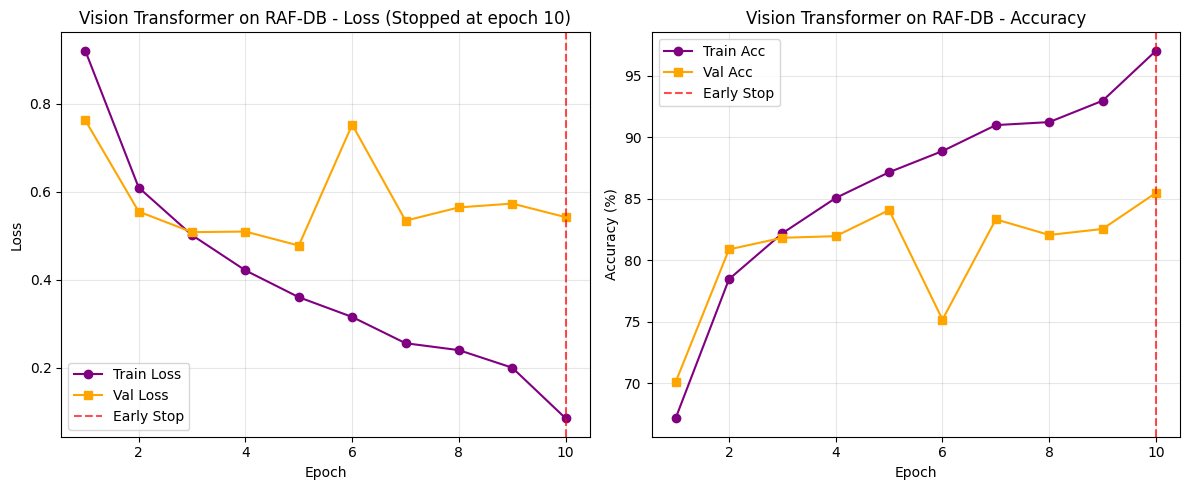

In [42]:
# Plotting results for Vision Transformer
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

epochs_range = range(1, len(vit_results['train_losses']) + 1)

# Plot losses
axes[0].plot(epochs_range, vit_results['train_losses'], label='Train Loss', marker='o', color='purple')
axes[0].plot(epochs_range, vit_results['val_losses'], label='Val Loss', marker='s', color='orange')
axes[0].axvline(x=vit_results['stopped_epoch'], color='red', linestyle='--', alpha=0.7, label='Early Stop')
axes[0].set_title(f'Vision Transformer on RAF-DB - Loss (Stopped at epoch {vit_results["stopped_epoch"]})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracies
axes[1].plot(epochs_range, vit_results['train_accs'], label='Train Acc', marker='o', color='purple')
axes[1].plot(epochs_range, vit_results['val_accs'], label='Val Acc', marker='s', color='orange')
axes[1].axvline(x=vit_results['stopped_epoch'], color='red', linestyle='--', alpha=0.7, label='Early Stop')
axes[1].set_title('Vision Transformer on RAF-DB - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vit_rafdb_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


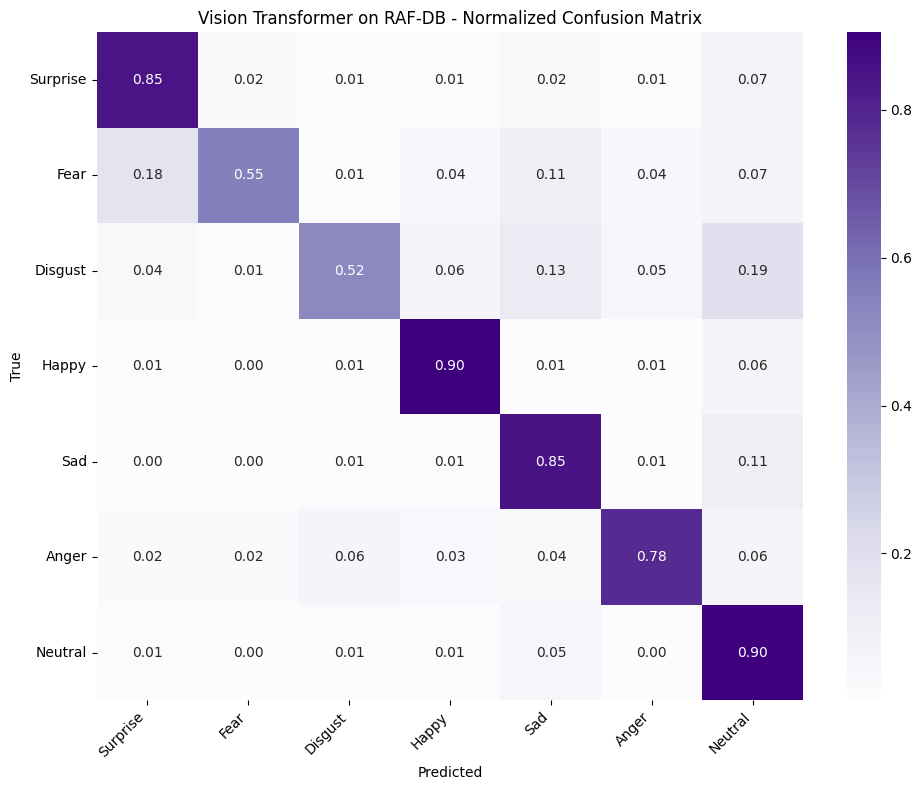

In [43]:
# Confusion matrix for Vision Transformer
plt.figure(figsize=(10, 8))
cm = confusion_matrix(vit_results['true_labels'], vit_results['predictions'])

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Purples', 
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Vision Transformer on RAF-DB - Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('vit_rafdb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Classification report for Vision Transformer
print("\n" + "="*60)
print("VISION TRANSFORMER ON RAF-DB - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(vit_results['true_labels'], vit_results['predictions'], 
                           target_names=EMOTIONS, zero_division=0, digits=4))

# Per-class performance analysis
print(f"\n📈 Detailed Analysis for Vision Transformer on RAF-DB:")
cm = confusion_matrix(vit_results['true_labels'], vit_results['predictions'])


VISION TRANSFORMER ON RAF-DB - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Surprise     0.8558    0.8480    0.8519       329
        Fear     0.7193    0.5541    0.6260        74
     Disgust     0.7034    0.5188    0.5971       160
       Happy     0.9675    0.9046    0.9350      1185
         Sad     0.8256    0.8515    0.8383       478
       Anger     0.8182    0.7778    0.7975       162
     Neutral     0.7574    0.9044    0.8244       680

    accuracy                         0.8550      3068
   macro avg     0.8067    0.7656    0.7815      3068
weighted avg     0.8592    0.8550    0.8542      3068


📈 Detailed Analysis for Vision Transformer on RAF-DB:


In [45]:
# Calculate per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print(f"\n{'Emotion':<15} {'Accuracy':<15}")
print("-"*30)
for emotion, acc in zip(EMOTIONS, class_acc):
    print(f"{emotion:<15} {acc*100:.2f}%")

# Find easiest and hardest emotions
best_class_idx = np.argmax(class_acc)
worst_class_idx = np.argmin(class_acc)
print(f"\n✅ Best performing emotion: {EMOTIONS[best_class_idx]} ({class_acc[best_class_idx]*100:.2f}%)")
print(f"❌ Worst performing emotion: {EMOTIONS[worst_class_idx]} ({class_acc[worst_class_idx]*100:.2f}%)")



Emotion         Accuracy       
------------------------------
Surprise        84.80%
Fear            55.41%
Disgust         51.88%
Happy           90.46%
Sad             85.15%
Anger           77.78%
Neutral         90.44%

✅ Best performing emotion: Happy (90.46%)
❌ Worst performing emotion: Disgust (51.88%)


In [46]:
# Sample predictions with best model
print("\n📝 Sample predictions with Vision Transformer on RAF-DB:")
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:8].to(device)
sample_labels = sample_labels[:8]

vit.eval()
with torch.no_grad():
    outputs = vit(sample_images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence, predicted = probabilities.max(1)

# Emoji mapping for emotions
def get_emotion_emoji(emotion):
    emoji_map = {
        'Surprise': '😲', 'Fear': '😨', 'Disgust': '🤢', 'Happy': '😊',
        'Sad': '😢', 'Anger': '😠', 'Neutral': '😐'
    }
    return emoji_map.get(emotion, '❓')

print(f"\n{'True Label':<20} {'Predicted':<20} {'Confidence':<15}")
print("-"*55)
for true, pred, conf in zip(sample_labels, predicted.cpu(), confidence.cpu()):
    true_emoji = get_emotion_emoji(EMOTIONS[true])
    pred_emoji = get_emotion_emoji(EMOTIONS[pred])
    print(f"{true_emoji} {EMOTIONS[true]:<17} {pred_emoji} {EMOTIONS[pred]:<17} {conf:.4f}")

# Save results
print(f"\n📁 Vision Transformer results saved to 'vit_rafdb_results.csv'")
print(f"   Best validation accuracy: {vit_results['best_val_acc']:.2f}%")
print(f"   Stopped at epoch: {vit_results['stopped_epoch']}")
print(f"   Total epochs trained: {len(vit_results['train_accs'])}")


📝 Sample predictions with Vision Transformer on RAF-DB:

True Label           Predicted            Confidence     
-------------------------------------------------------
😲 Surprise          😲 Surprise          0.9092
😲 Surprise          😲 Surprise          0.9977
😲 Surprise          😲 Surprise          0.7207
😲 Surprise          😲 Surprise          0.9996
😲 Surprise          😲 Surprise          0.9999
😲 Surprise          😲 Surprise          0.9806
😲 Surprise          😲 Surprise          0.9999
😲 Surprise          😲 Surprise          0.9998

📁 Vision Transformer results saved to 'vit_rafdb_results.csv'
   Best validation accuracy: 85.50%
   Stopped at epoch: 10
   Total epochs trained: 10
